In [56]:
# TODO: これまでやってきた取り組みを遡ってスコア計測したい
# スコア計測して取り組みとスコアの推移を記録したら発表に使えるかも

In [57]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabelSequence, crf_label
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [59]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabelSequence.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabelSequence.from_abbreviation, data_test))

In [60]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [61]:
y_pred = model.predict(X_test)

In [62]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.6986186479224926

In [63]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] != crf_label.NG:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = (np.array(y_pred[i]) == y_test[i]).mean()
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

0.500 a po i N to me N to -> a po i N to
0.333 da N su do ri ru -> da N su
1.000 ho ri e chi re N -> ho ri
1.000 ma ji Q ku na N ba a -> ma ji Q ku
1.000 shi N po ji u mu -> shi N po
1.000 fu ra Q shu ba ru bu -> fu ra Q shu
1.000 go no ri i a -> go no
0.429 fa N do to ra su to -> fa N do
0.600 pu ro gu re Q shi pu ro Q ku -> pu ro gu re Q shi pu
0.714 su ki zo fu re ni a -> su ki
0.625 ne ga thi bu ko me N to -> ne ga ko me N to
1.000 ri i ze N to su ta i ru -> ri i ze N to
0.500 pu chi bu ru jo a -> pu chi
1.000 a N da a ka ba a e e je N to -> a N da a ka ba a
0.000 ra N chi i ko o cha a -> ra N chi i
0.600 ko N pa ni i -> ko N
0.727 su ta a ba Q ku su ko o hi i -> su ta a
1.000 ba Q ku ha N do -> ba Q ku
0.769 so o sha ru me dhi a ha ra su me N to -> so o sha ru ha ra
1.000 bi fu te ki -> te ki
0.400 pa a so na ru ko N pyu u ta -> pa a so na ru
0.333 yo o do chi N ki -> yo o do
1.000 re fu re ku ta a -> re fu
1.000 ko N sa ru thi N gu -> ko N sa ru
0.700 ka ru shu u mu ka a ba i do 

In [64]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.5118110236220472


In [65]:
score_list.mean()

0.702842136248806

(array([ 27.,   5.,  10.,   7.,  19.,  31.,  13.,  11.,   1., 130.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

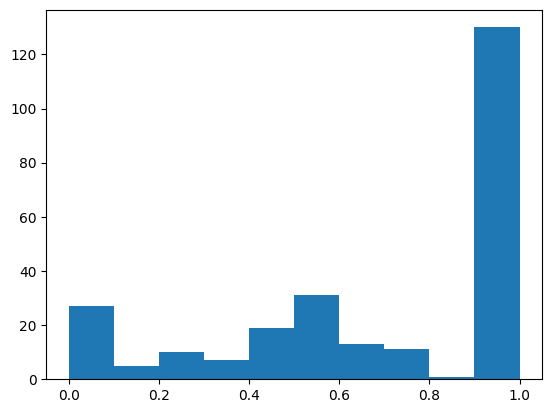

In [66]:
plt.hist(score_list, bins=10)